# Introduction to pyMOR

## What is pyMOR?

* #### A software library for building model order reduction applications with *Python*
* #### Free and open source

## How did pyMOR start?

* #### Project started in October 2012
* #### Founding members were based at the University of Münster, Germany
* #### Started off as a library for applying the reduced-basis method
* #### Original motivation: Decouple MOR algorithms from large-scale models
    * #### Proprietary code for battery simulation models could not be shared with MOR experts
    * #### Can we still do model reduction without access to the model?

<table width=70%>
    <tr>
        <td><img src="figs/renefritze.jpg"></td>
        <td><img src="figs/sdrave.jpg"></td>
        <td><img src="figs/ftschindler.jpg"></td>
    </tr>
    <tr>
        <td>René Fritze</td>
        <td>Stephan Rave</td>
        <td>Felix Schindler</td>
    </tr>
</table>
<br>




## Where is pyMOR now?

* #### Over 40 people have contributed, with 5 designated main developers
* #### General purpose software library for MOR algorithm prototyping and large-scale computations
* #### Linear algebra and MOR algorithms from various research communities:
    * #### Randomized linear algebra (SVD, eigenvalue solvers, ...)
    * #### Balanced Truncation
    * #### IRKA
    * #### AAA/Loewner
    * #### Reduced basis method (RBM)
    * #### POD
    * #### ...

<table width=70%>
    <tr>
        <td><img src="figs/pmli.jpg"></td>
        <td><img src="figs/HenKlei.jpg"></td>
        <td><img src="figs/sdrave.jpg"></td>
        <td><img src="figs/ftschindler.jpg"></td>
        <td><img src="figs/lbalicki.jpg"></td>
    </tr>
    <tr>
        <td>Petar Mlinarić</td>
        <td>Hendrik Kleikamp</td>
        <td>Stephan Rave</td>
        <td>Felix Schindler</td>
        <td>Linus Balicki</td>
    </tr>
</table>
<br>
<br>
<br>

## Imports and Settings

In [1]:
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt
from pymor.core.logger import set_log_levels

plt.rcParams['axes.grid'] = True
set_log_levels({
    'pymor.algorithms.gram_schmidt.gram_schmidt': 'WARNING',
    'pymor.reductors.basic.LTIPGReductor': 'WARNING',
})

## pyMOR Structure

<img src="figs/pyMOR-structure.jpg">

## LTI Models in pyMOR

#### How do we create a basic LTI model?

$$
\begin{align*}
\dot{\mathbf{x}}(t) &= \mathbf{A} \mathbf{x}(t) + \mathbf{B} u(t) \\ 
y(t) &= \mathbf{C} \mathbf{x}(t)
\end{align*}
$$

In [2]:
from pymor.models.iosys import LTIModel

A = np.random.rand(10,10)
B = np.random.rand(10,1)
C = np.random.rand(1,10)

lti = LTIModel.from_matrices(A,B,C)

In [3]:
print(lti)

LTIModel
    class: LTIModel
    number of equations: 10
    number of inputs:    1
    number of outputs:   1
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(10, id='STATE')


In [38]:
lti

LTIModel(
    NumpyMatrixOperator(<10x10 dense>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<10x1 dense>, range_id='STATE'),
    NumpyMatrixOperator(<1x10 dense>, source_id='STATE'),
    D=ZeroOperator(NumpyVectorSpace(1), NumpyVectorSpace(1)),
    E=IdentityOperator(NumpyVectorSpace(10, id='STATE')),
    presets={})

In [4]:
lti.A

NumpyMatrixOperator(<10x10 dense>, source_id='STATE', range_id='STATE')

#### What are these NumpyMatrixOperators?

* #### pyMOR supports various Operators which can handle many different things
    * #### "Black-box" evaluations coupled to an external PDE solver
    * #### MPI distributed computations
    * #### Structured matrices (banded, block, Hankel, ...)
    * #### Nonlinear operators (e.g. quadratic $\mathbf{N} (\mathbf{x}(t) \otimes \mathbf{x}(t)$)
    * #### Simply a numpy matrix &#8594; NumpyMatrixOperator
* #### Operators allow for decoupling the MOR algorithms from the linear algebra backend of the large-scale model

In [5]:
lti.A.matrix

array([[0.24397453, 0.31466881, 0.34330864, 0.35056096, 0.13260084,
        0.44927401, 0.66556951, 0.29508467, 0.91068158, 0.03324097],
       [0.41508558, 0.8707955 , 0.3588128 , 0.0219018 , 0.01267075,
        0.98303834, 0.17369094, 0.79063723, 0.19572467, 0.09562272],
       [0.78137518, 0.97774044, 0.23181875, 0.33345556, 0.92386165,
        0.66426152, 0.61993107, 0.17048649, 0.41689379, 0.82064887],
       [0.52191221, 0.69555242, 0.35218654, 0.57743967, 0.7229802 ,
        0.42000587, 0.82119372, 0.76560065, 0.1781746 , 0.56274462],
       [0.53077622, 0.8215839 , 0.96085762, 0.50586843, 0.09356457,
        0.26503449, 0.05203758, 0.53562493, 0.56505945, 0.56834118],
       [0.60914954, 0.41988209, 0.48766106, 0.89391311, 0.90276044,
        0.39628041, 0.10176382, 0.16859524, 0.07265983, 0.78378706],
       [0.03113542, 0.65827962, 0.06839698, 0.44821443, 0.15229355,
        0.11613121, 0.0046174 , 0.38158511, 0.39325114, 0.78488058],
       [0.34276537, 0.61557674, 0.7889334

## Rail Model

In [6]:
from pymor.models.iosys import LTIModel

rail_fom = LTIModel.from_abcde_files('data/rail/rail_5177_c60')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [7]:
print(rail_fom)

LTIModel
    class: LTIModel
    number of equations: 5177
    number of inputs:    7
    number of outputs:   6
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(5177, id='STATE')


In [8]:
rail_fom.A

NumpyMatrixOperator(<5177x5177 sparse, 35185 nnz>, source_id='STATE', range_id='STATE')

In [9]:
rail_fom.A.matrix

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 35185 stored elements and shape (5177, 5177)>

## Transfer Function
$$
\mathbf{H}(s) = \mathbf{C}(s\mathbf{I} - \mathbf{A})^{-1} \mathbf{B}
$$

In [10]:
print(rail_fom.transfer_function)

LTIModel_transfer_function
    class: FactorizedTransferFunction
    number of inputs:  7
    number of outputs: 6
    continuous-time


In [14]:
rail_fom.transfer_function.eval_tf(1e-4j)

array([[ 1.79487135e-04+3.19296603e-04j,  8.26558519e-05+2.76569367e-04j,
        -5.71947632e-04+5.68066101e-04j, -1.35159026e-02-1.71628390e-02j,
        -9.86030020e-04-6.34778986e-02j, -3.41207121e-03-1.61263168e-02j,
         4.26239436e-03-6.84064064e-02j],
       [ 1.57045013e-05+3.98923678e-05j,  5.16047718e-06+3.33895730e-05j,
        -7.54014188e-05+5.67186413e-05j, -1.29160610e-03-2.20618075e-03j,
        -1.45904748e-02-5.15286120e-03j, -4.02464088e-02+1.10496984e-03j,
        -7.86541230e-03-5.47083871e-03j],
       [-5.86929416e-04+2.17586919e-05j, -4.54986637e-04-8.49783826e-05j,
        -3.90544426e-04-1.23217780e-03j, -6.99000685e-03-9.06615409e-03j,
        -2.12384736e-03+3.53224096e-03j,  3.28064049e-04+6.89510726e-04j,
         5.81138848e-05+3.31898844e-03j],
       [-5.89855995e-04-1.63130431e-03j, -1.86301415e-04-1.34897322e-03j,
         1.57449959e-03-2.16256299e-03j, -1.86973674e-02+4.80447608e-03j,
         3.31894252e-04+2.97228792e-04j,  8.00786615e-05-2.0

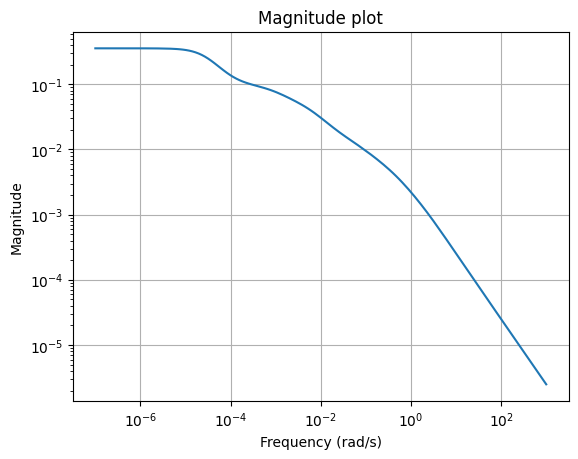

In [11]:
w = (1e-7, 1e3)
_ = rail_fom.transfer_function.mag_plot(w)

## Hankel Singular Values

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

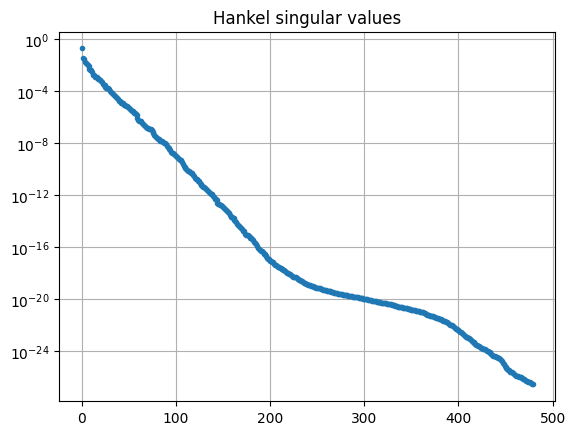

In [15]:
rail_hsv = rail_fom.hsv()

fig, ax = plt.subplots()
_ = ax.semilogy(rail_hsv, '.')
_ = ax.set_title('Hankel singular values')

## Balanced Truncation

In [17]:
from pymor.reductors.bt import BTReductor

rail_bt = BTReductor(rail_fom)

rail_rom_bt = rail_bt.reduce(20)

print(rail_rom_bt)

LTIModel_reduced
    class: LTIModel
    number of equations: 20
    number of inputs:    7
    number of outputs:   6
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(20)


In [18]:
rail_bt.reduce?

Signature: rail_bt.reduce(r=None, tol=None, projection='bfsr')
Docstring:
Generic Balanced Truncation.

Parameters
----------
r
    Order of the reduced model if `tol` is `None`, maximum order if `tol` is specified.
tol
    Tolerance for the error bound if `r` is `None`.
projection
    Projection method used:

    - `'sr'`: square root method
    - `'bfsr'`: balancing-free square root method (default, since it avoids scaling by
      singular values and orthogonalizes the projection matrices, which might make it more
      accurate than the square root method)
    - `'biorth'`: like the balancing-free square root method, except it biorthogonalizes the
      projection matrices (using :func:`~pymor.algorithms.gram_schmidt.gram_schmidt_biorth`)

Returns
-------
rom
    Reduced-order model.
File:      ~/Desktop/pymor-intro/.venv/lib/python3.10/site-packages/pymor/reductors/bt.py
Type:      method

In [24]:
rail_rom_bt.A.matrix

array([[-2.28647595e-09, -1.27375374e-09,  8.76229378e-10,
         1.66113710e-08,  2.83558689e-08, -2.48227397e-11,
         2.93250149e-08,  5.87840544e-10,  3.43898626e-09,
        -3.61766837e-09, -6.60029671e-10,  1.94795374e-09,
         9.15152448e-09,  2.99619594e-09, -2.43934087e-11,
        -9.70769749e-10, -5.36911880e-09, -7.49850685e-09,
         6.84868135e-10, -4.58724114e-09],
       [ 1.65424631e-10, -1.66294123e-08, -5.16063674e-08,
        -1.62359912e-08,  1.86324007e-08,  4.15416961e-08,
         6.88615645e-09,  1.31880278e-09, -2.77022620e-08,
        -2.11007467e-08,  1.25028388e-07,  3.02310163e-09,
        -5.16211567e-09,  1.20497417e-08,  2.40763305e-08,
         8.52207342e-08, -4.66325814e-09, -5.66783687e-09,
         3.50621409e-08, -8.33073836e-09],
       [-1.95515507e-09, -1.04260585e-09, -4.86906380e-09,
        -4.02431815e-08, -7.55162595e-08,  1.14404802e-08,
        -4.88682383e-08,  1.48755978e-09, -2.81162011e-09,
        -4.16708011e-08,  8.0

## BT Poles

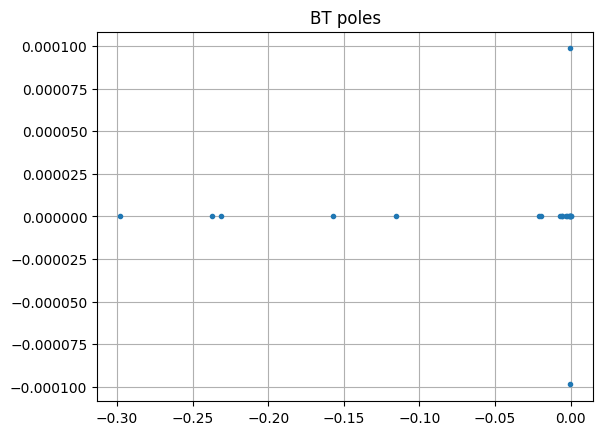

In [25]:
fig, ax = plt.subplots()
poles = rail_rom_bt.poles()
_ = ax.plot(poles.real, poles.imag, '.')
_ = ax.set_title('BT poles')

In [26]:
poles.real.max()

-1.841041389485514e-05

## FOM and BT Magnitude Plots

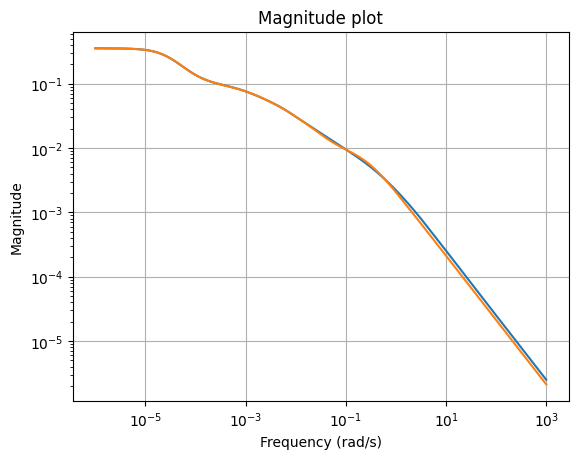

In [27]:
w = (1e-6, 1e3)
_ = rail_fom.transfer_function.mag_plot(w)
_ = rail_rom_bt.transfer_function.mag_plot(w)

## Time-Domain Simulations

In [34]:
from pymor.algorithms.timestepping import ImplicitEulerTimeStepper

rail_rom_bt = rail_rom_bt.with_(T=10, time_stepper=ImplicitEulerTimeStepper(100))

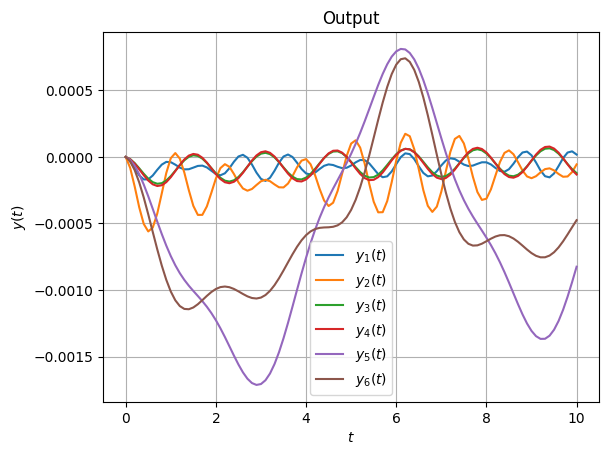

In [35]:
Y = rail_rom_bt.output(input='[sin(t[0]), sin(2 * t[0]), sin(3 * t[0]), sin(4 * t[0]), sin(5 * t[0]), sin(6 * t[0]),  sin(7 * t[0])]')
fig, ax = plt.subplots()
for i, y in enumerate(Y.T):
    ax.plot(np.linspace(0, rail_rom_bt.T, rail_rom_bt.time_stepper.nt + 1), y, label=f'$y_{i+1}(t)$')
_ = ax.set(xlabel='$t$', ylabel='$y(t)$', title='Output')
_ = ax.legend()

## BT Error System

In [36]:
rail_err_bt = rail_fom - rail_rom_bt

In [40]:
print(rail_err_bt)

LTIModel
    class: LTIModel
    number of equations: 5197
    number of inputs:    7
    number of outputs:   6
    continuous-time
    linear time-invariant
    solution_space:  BlockVectorSpace((NumpyVectorSpace(5177, id='STATE'), NumpyVectorSpace(20)))


In [43]:
rail_err_bt

LTIModel(
    BlockDiagonalOperator(
        array([[NumpyMatrixOperator(<5177x5177 sparse, 35185 nnz>, source_id='STATE', range_id='STATE'),
                ZeroOperator(NumpyVectorSpace(5177, id='STATE'), NumpyVectorSpace(20))],
               [ZeroOperator(NumpyVectorSpace(20), NumpyVectorSpace(5177, id='STATE')),
                NumpyMatrixOperator(<20x20 dense>)]], dtype=object)),
    BlockColumnOperator(
        array([[NumpyMatrixOperator(<5177x7 sparse, 345 nnz>, range_id='STATE')],
               [NumpyMatrixOperator(<20x7 dense>)]], dtype=object)),
    BlockRowOperator(
        array([[NumpyMatrixOperator(<6x5177 sparse, 17 nnz>, source_id='STATE'),
                LincombOperator((NumpyMatrixOperator(<6x20 dense>)), (-1.0))]],
              dtype=object)),
    D=LincombOperator(
          (ZeroOperator(NumpyVectorSpace(6), NumpyVectorSpace(7)),
           ZeroOperator(NumpyVectorSpace(6), NumpyVectorSpace(7))),
          (1.0, -1.0)),
    E=BlockDiagonalOperator(
          a

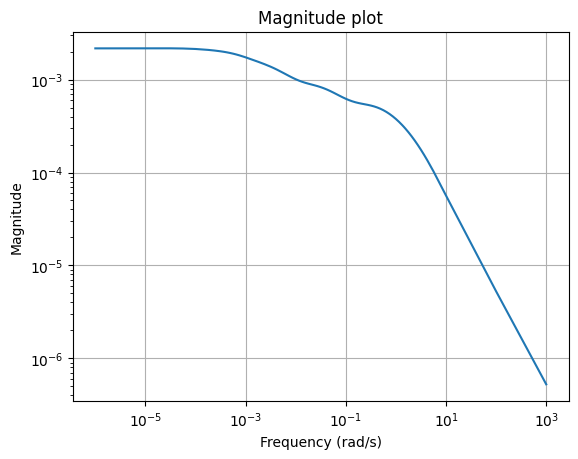

In [44]:
_ = rail_err_bt.transfer_function.mag_plot(w)

## $\mathcal{H}_2$ Relative Error

In [45]:
rail_err_bt.h2_norm() / rail_fom.h2_norm()

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

0.0828376888361642

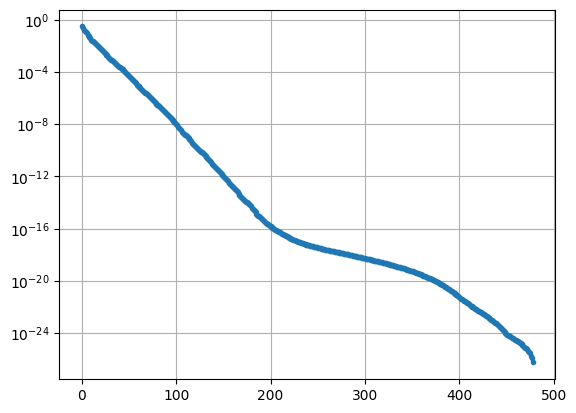

In [47]:
_ = plt.semilogy(rail_bt.error_bounds(), '.-')

## IRKA

In [48]:
from pymor.reductors.h2 import IRKAReductor

rail_irka = IRKAReductor(rail_fom)

In [53]:
rail_rom_irka = rail_irka.reduce(20, conv_crit='h2', tol=1e-2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [54]:
rail_rom_irka

LTIModel(
    NumpyMatrixOperator(<20x20 dense>),
    NumpyMatrixOperator(<20x7 dense>),
    NumpyMatrixOperator(<6x20 dense>),
    D=ZeroOperator(NumpyVectorSpace(6), NumpyVectorSpace(7)),
    E=NumpyMatrixOperator(<20x20 dense>),
    presets={},
    name='LTIModel_reduced')

## IRKA Convergence

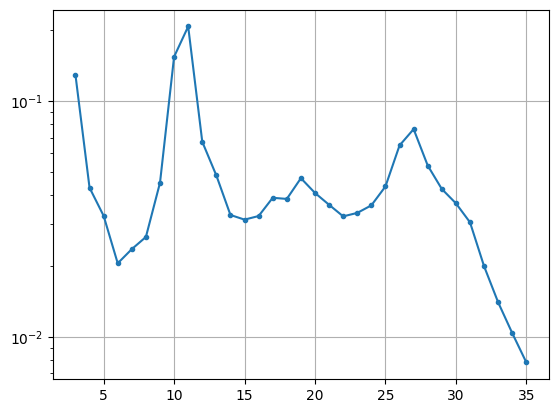

In [55]:
_ = plt.semilogy(rail_irka.conv_crit, '.-')

## IRKA Poles

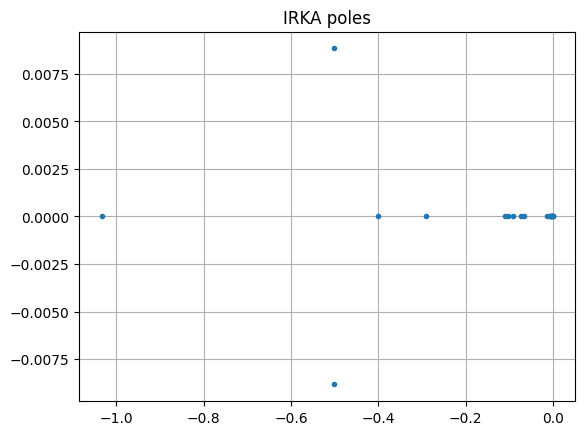

In [56]:
fig, ax = plt.subplots()
poles = rail_rom_irka.poles()
_ = ax.plot(poles.real, poles.imag, '.')
_ = ax.set_title('IRKA poles')


In [57]:
poles.real.max()

-2.8244123943348632e-05

## FOM and IRKA Magnitude Plots

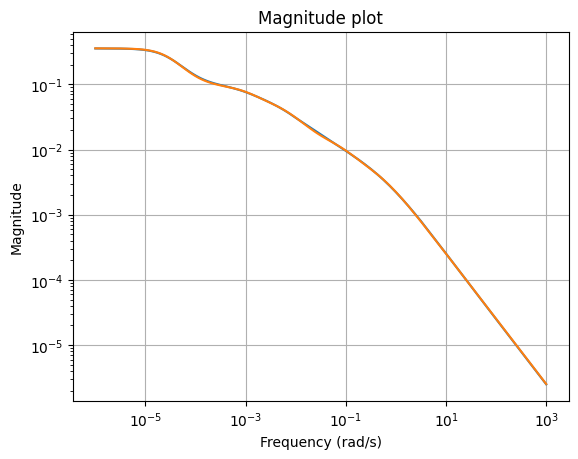

In [58]:
w = (1e-6, 1e3)
_ = rail_fom.transfer_function.mag_plot(w)
_ = rail_rom_irka.transfer_function.mag_plot(w)

## IRKA Error System

In [59]:
rail_err_irka = rail_fom - rail_rom_irka

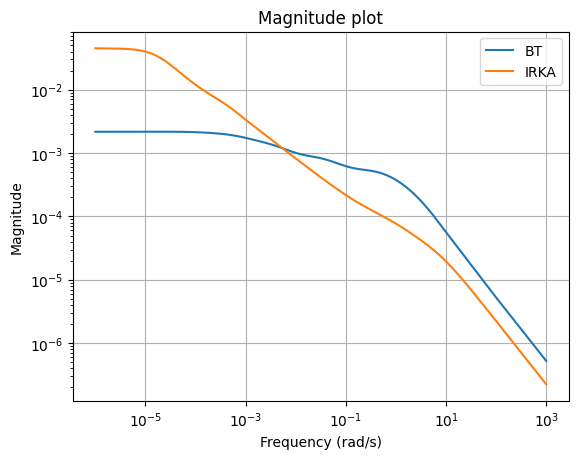

In [60]:
fig, ax = plt.subplots()
_ = rail_err_bt.transfer_function.mag_plot(w, ax=ax, label='BT')
_ = rail_err_irka.transfer_function.mag_plot(w, ax=ax, label='IRKA')
_ = ax.legend()

## $\mathcal{H}_2$ Relative Error

In [61]:
rail_err_irka.h2_norm() / rail_fom.h2_norm()

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

0.044714444077062425

## Transfer Function

#### Heat equation over a semi-infinite rod from \[Beattie/Gugercin '12\].

$$
\begin{align*}
  H(s) & = e^{-\sqrt{s}} \\
  H'(s) & = -\frac{e^{-\sqrt{s}}}{2 \sqrt{s}}
\end{align*}
$$

In [62]:
from pymor.models.transfer_function import TransferFunction

def H(s):
    return np.array([[np.exp(-np.sqrt(s))]])

def dH(s):
    return np.array([[-np.exp(-np.sqrt(s)) / (2 * np.sqrt(s))]])

tf = TransferFunction(
    1,
    1,
    H,
    dH,
)

In [64]:
print(tf)

TransferFunction
    class: TransferFunction
    number of inputs:  1
    number of outputs: 1
    continuous-time


## Bode Plot

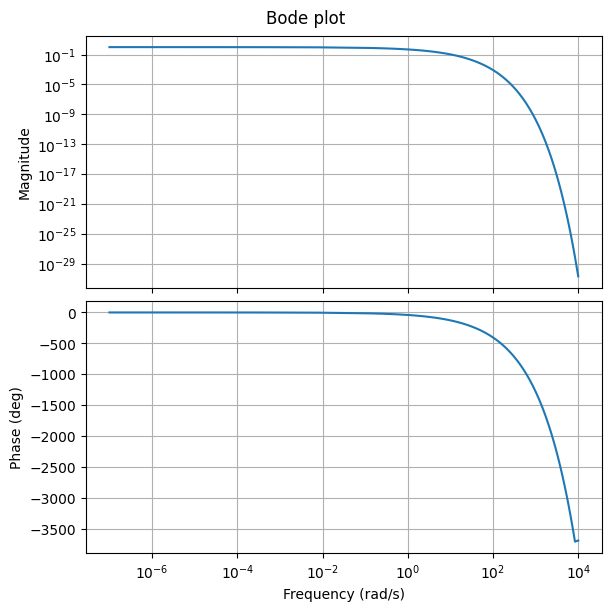

In [65]:
w_tf = (1e-7, 1e4)
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True, squeeze=False, constrained_layout=True)
_ = tf.bode_plot(w_tf, ax=ax)

## TF-IRKA

In [66]:
from pymor.reductors.h2 import TFIRKAReductor

tf_irka = TFIRKAReductor(tf)

In [67]:
tf_rom = tf_irka.reduce(20)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [68]:
tf_rom

LTIModel(
    NumpyMatrixOperator(<20x20 dense>, source_id='STATE', range_id='STATE'),
    NumpyMatrixOperator(<20x1 dense>, range_id='STATE'),
    NumpyMatrixOperator(<1x20 dense>, source_id='STATE'),
    D=ZeroOperator(NumpyVectorSpace(1), NumpyVectorSpace(1)),
    E=NumpyMatrixOperator(<20x20 dense>, source_id='STATE', range_id='STATE'),
    presets={})

## TF-IRKA Poles

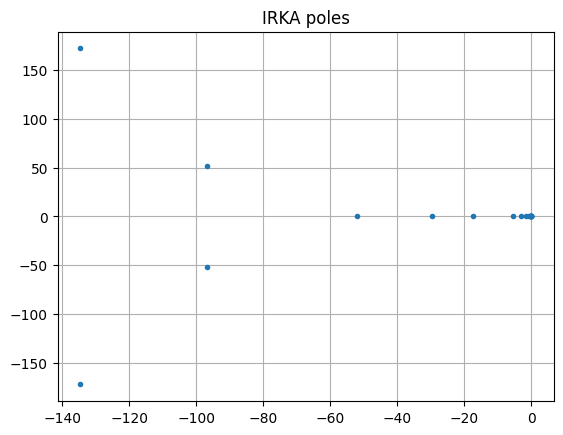

In [69]:
fig, ax = plt.subplots()
poles = tf_rom.poles()
_ = ax.plot(poles.real, poles.imag, '.')
_ = ax.set_title('IRKA poles')

In [70]:
poles.real.max()

-3.588117189581178e-05

## Bode Plots

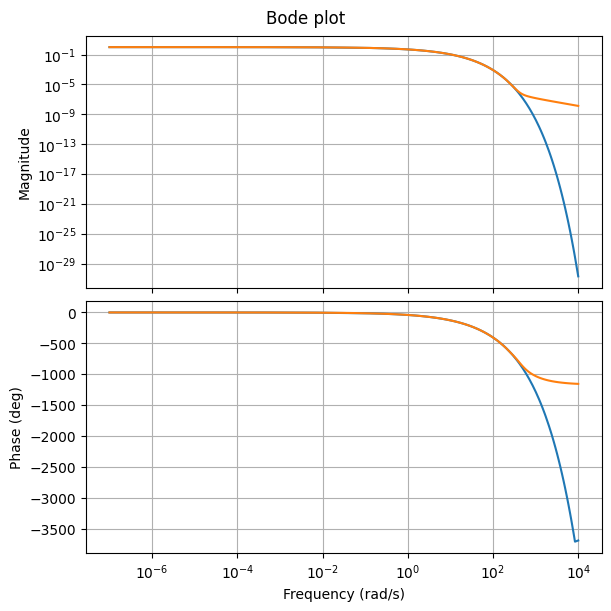

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True, squeeze=False, constrained_layout=True)
_ = tf.bode_plot(w_tf, ax=ax)
_ = tf_rom.transfer_function.bode_plot(w_tf, ax=ax)

## Error System

In [72]:
tf_err = tf - tf_rom

In [74]:
print(tf_err)

TransferFunction
    class: TransferFunction
    number of inputs:  1
    number of outputs: 1
    continuous-time


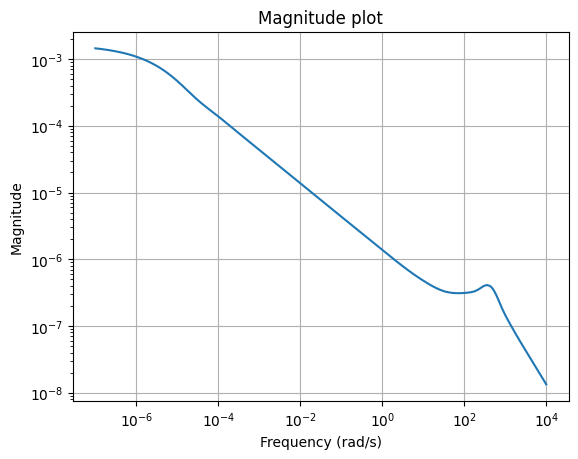

In [75]:
_ = tf_err.mag_plot(w_tf)

## Loewner

In [76]:
from pymor.reductors.loewner import LoewnerReductor

sampling_values = 1j * np.logspace(-4, 2, 100)
sampling_values = np.concatenate((sampling_values, -sampling_values))
loewner = LoewnerReductor(sampling_values, tf)

In [87]:
loewner_rom = loewner.reduce(r=20)

print(loewner_rom)

LTIModel
    class: LTIModel
    number of equations: 20
    number of inputs:    1
    number of outputs:   1
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(20, id='STATE')


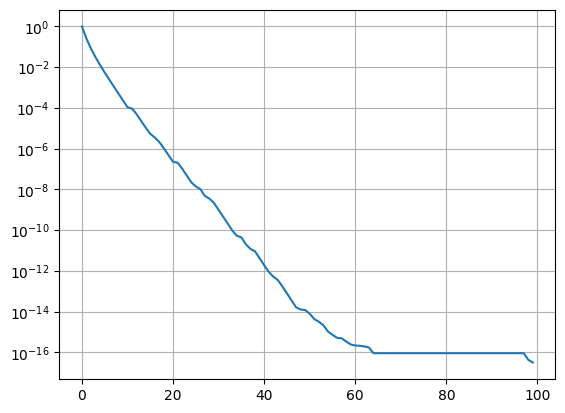

In [88]:
L, _, _, _ = loewner.loewner_quadruple()
_, S, _ = spla.svd(L)

plt.semilogy(S/S[0])

## Bode Plots

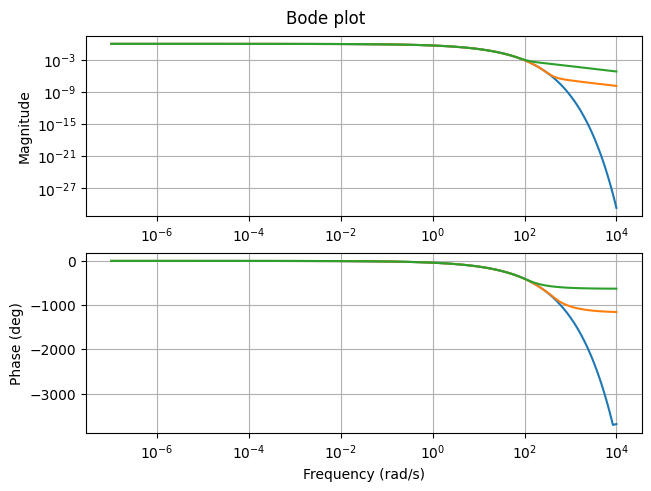

In [89]:
fig, ax = plt.subplots(2, 1, squeeze=False, constrained_layout=True)
_ = tf.bode_plot(w_tf, ax=ax)
_ = tf_rom.transfer_function.bode_plot(w_tf, ax=ax)
_ = loewner_rom.transfer_function.bode_plot(w_tf, ax=ax)

## Error System

In [90]:
loewner_err = tf - loewner_rom

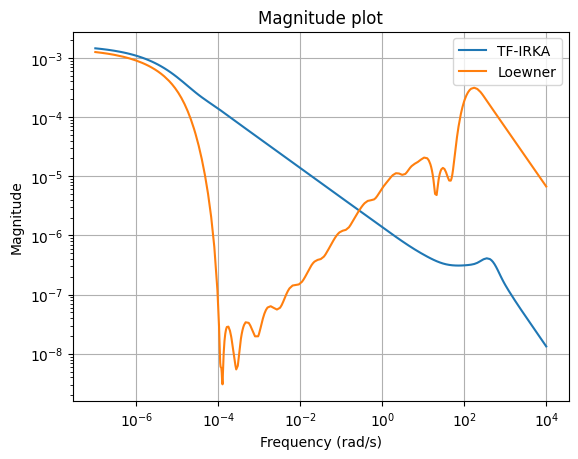

In [91]:
fig, ax = plt.subplots()
_ = tf_err.mag_plot(w_tf, ax=ax, label='TF-IRKA')
_ = loewner_err.mag_plot(w_tf, ax=ax, label='Loewner')
_ = ax.legend()

## Parametric LTI Models

#### Cookie model (thermal block) example from [MOR Wiki](https://morwiki.mpi-magdeburg.mpg.de/morwiki/index.php/Thermal_Block).

$$
$$
\begin{align*}
\mathbf{E} \dot{\mathbf{x}}(t,p) &= \mathbf{A}(p) \mathbf{x}(t,p) + \mathbf{B} u(t) \\ 
y(t,p) &= \mathbf{C} \mathbf{x}(t,p)
\end{align*}
$$
$$

#### where

$$
\mathbf{A}(p) = \mathbf{A}_0 + p \tilde{\mathbf{A}}
$$

In [114]:
import scipy.io as spio

mat = spio.loadmat('data/cookie/ABCE.mat')

In [115]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A0', 'A1', 'A2', 'A3', 'A4', 'B', 'C', 'E'])

In [116]:
A0 = mat['A0']
Atilde = 0.2 * mat['A1'] + 0.4 * mat['A2'] + 0.6 * mat['A3'] + 0.8 * mat['A4']
B = mat['B']
C = mat['C']
E = mat['E']

In [117]:
A0

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 45343 stored elements and shape (7488, 7488)>

In [118]:
from pymor.operators.numpy import NumpyMatrixOperator

A0op = NumpyMatrixOperator(A0)
Atildeop = NumpyMatrixOperator(Atilde)
Bop = NumpyMatrixOperator(B)
Cop = NumpyMatrixOperator(C)
Eop = NumpyMatrixOperator(E)

In [119]:
A0op

NumpyMatrixOperator(<7488x7488 sparse, 45343 nnz>)

In [120]:
from pymor.parameters.functionals import ProjectionParameterFunctional

Aop = A0op + ProjectionParameterFunctional('p') * Atildeop

In [121]:
Aop

LincombOperator(
    (NumpyMatrixOperator(<7488x7488 sparse, 45343 nnz>), NumpyMatrixOperator(<7488x7488 sparse, 7075 nnz>)),
    (1.0, ProjectionParameterFunctional('p', index=0)))

In [122]:
cookie_fom = LTIModel(Aop, Bop, Cop, E=Eop)

In [123]:
print(cookie_fom)

LTIModel
    class: LTIModel
    number of equations: 7488
    number of inputs:    1
    number of outputs:   4
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(7488)


In [124]:
cookie_fom.parameters

Parameters({p: 1})

## Magnitude Plot

In [125]:
num_w = 10
num_p = 10
ws = np.logspace(-4, 4, num_w)
ps = np.logspace(-6, 2, num_p)
Hwp = np.empty((num_p, num_w))
for i in range(num_p):
    Hwp[i] = spla.norm(cookie_fom.transfer_function.freq_resp(ws, mu=ps[i]), axis=(1, 2))

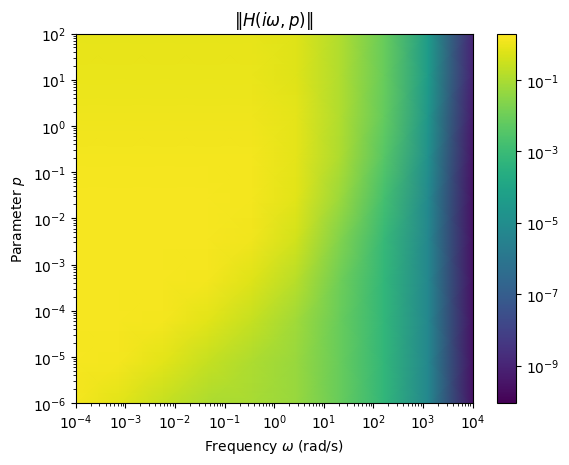

In [126]:
from matplotlib.colors import LogNorm

lognorm = LogNorm(vmin=9e-11, vmax=2)

fig, ax = plt.subplots()
out = ax.pcolormesh(ws, ps, Hwp, shading='gouraud', norm=lognorm)
ax.set(
    xscale='log',
    yscale='log',
    xlabel=r'Frequency $\omega$ (rad/s)',
    ylabel='Parameter $p$',
    title=r'$\Vert H(i \omega, p) \Vert$',
)
ax.grid(False)
_ = fig.colorbar(out)


## Global Basis via Interpolation

#### For several parameters and frequencies compute

$$
\begin{align*}
\mathbf{V} &= [(s_1\mathbf{I} - \mathbf{A}(p_1))^{-1} \mathbf{B} b, ... , (s_n\mathbf{I} - \mathbf{A}(p_m))^{-1} \mathbf{B} b] \\
\mathbf{W} &= [(s_1\mathbf{I} - \mathbf{A}(p_1))^{-*} \mathbf{C}^\top c, ... , (s_n\mathbf{I} - \mathbf{A}(p_m))^{-*} \mathbf{C}^\top c]
\end{align*}
$$

#### and compute the reduced order model via Petrov-Galerkin projection, e.g.,

$$
\mathbf{W}^\top \mathbf{A}(p) \mathbf{V} = \mathbf{W}^\top \mathbf{A}_0 \mathbf{V} + p \mathbf{W}^\top \tilde{\mathbf{A}} \mathbf{V}
$$



In [127]:
from pymor.algorithms.gram_schmidt import gram_schmidt
from pymor.reductors.interpolation import LTIBHIReductor

s_samples = np.logspace(-1, 1, 5)
s_samples = np.concatenate((1j * s_samples, -1j * s_samples))
p_samples = np.logspace(-3, -1, 5)
V = cookie_fom.A.source.empty()
W = cookie_fom.A.source.empty()
for p in p_samples:
    interp = LTIBHIReductor(cookie_fom, mu=p)
    interp.reduce(s_samples, np.ones((len(s_samples), 1)), np.ones((len(s_samples), 4)))
    V.append(interp.V)
    W.append(interp.W)

_ = gram_schmidt(V, copy=False)
_ = gram_schmidt(W, copy=False)


In [128]:
V

NumpyVectorArray(
    NumpyVectorSpace(7488),
    [[ 0.00000000e+00  2.51321276e-04  1.63665698e-04 ...  1.96197432e-02
       1.97658068e-02  1.97639887e-02]
     [ 0.00000000e+00  2.13203855e-05  1.38786844e-05 ...  5.15695013e-03
       5.25335472e-03  5.25263810e-03]
     [ 0.00000000e+00  8.44679122e-05  5.50135271e-05 ...  2.40281160e-04
       1.12582270e-04  1.13319923e-04]
     ...
     [ 0.00000000e+00 -1.28478866e-03 -8.37700698e-04 ...  2.09176586e-02
       3.06803407e-02  3.05572364e-02]
     [ 0.00000000e+00 -1.42259587e-04 -9.41225471e-05 ... -8.85064886e-03
      -2.69799749e-02 -2.63284179e-02]
     [ 0.00000000e+00 -1.04972734e-03 -6.84580888e-04 ... -6.39531952e-03
      -1.71934812e-02 -1.64296568e-02]],
    _len=50)

In [129]:
from pymor.reductors.basic import LTIPGReductor

pg = LTIPGReductor(cookie_fom, W, V)
cookie_rom = pg.reduce()

In [130]:
cookie_rom

LTIModel(
    LincombOperator(
        (NumpyMatrixOperator(<50x50 dense>), NumpyMatrixOperator(<50x50 dense>)),
        (1.0, ProjectionParameterFunctional('p', index=0))),
    NumpyMatrixOperator(<50x1 dense>),
    NumpyMatrixOperator(<4x50 dense>),
    D=ZeroOperator(NumpyVectorSpace(4), NumpyVectorSpace(1)),
    E=NumpyMatrixOperator(<50x50 dense>),
    presets={},
    name='LTIModel_reduced')

## Error System

In [131]:
cookie_err = cookie_fom - cookie_rom

In [132]:
Hwp_err = np.empty((num_p, num_w))
for i in range(num_p):
    Hwp_err[i] = spla.norm(cookie_err.transfer_function.freq_resp(ws, mu=ps[i]), axis=(1, 2))


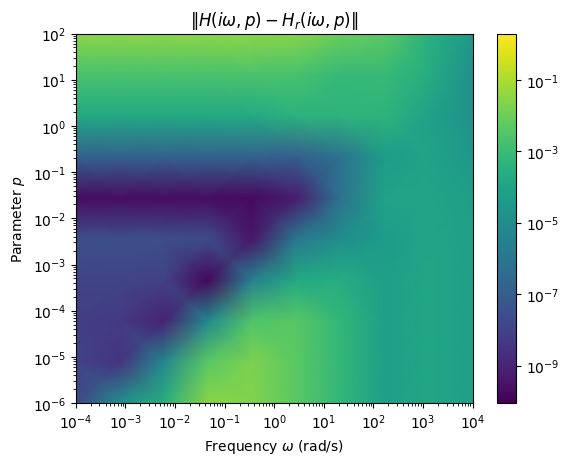

In [133]:
fig, ax = plt.subplots()
out = ax.pcolormesh(ws, ps, Hwp_err, shading='gouraud', norm=lognorm)
ax.set(
    xscale='log',
    yscale='log',
    xlabel=r'Frequency $\omega$ (rad/s)',
    ylabel='Parameter $p$',
    title=r'$\Vert H(i \omega, p) - H_r(i \omega, p) \Vert$',
)
ax.grid(False)
_ = fig.colorbar(out)


## ROM Poles

In [134]:
for p in ps:
    poles = cookie_rom.poles(mu=p)
    print(poles.real.max())

555.3371887479135
555.2271330303099
554.3759143224529
547.8378790091533
499.7906891473866
145.28465028424577
-1.0000002732252098
11.67287282510259
3047.7866754407937
27972.94608063607


## Galerkin Projection

In [135]:
from pymor.algorithms.pod import pod

VW = V.copy()
VW.append(W)
VW, svals = pod(VW)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [136]:
VW

NumpyVectorArray(
    NumpyVectorSpace(7488),
    [[ 3.41087216e-10  1.96330365e-06  1.28159874e-06 ...  1.61011365e-03
       1.61002781e-03  1.61007667e-03]
     [-5.15522485e-09 -3.45995055e-05 -2.26090941e-05 ... -2.50210910e-02
      -2.50178511e-02 -2.50262860e-02]
     [-7.47606104e-09  1.86424065e-04  1.21380788e-04 ... -8.74073253e-03
      -8.73651117e-03 -8.74301588e-03]
     ...
     [ 3.97965785e-03  1.06009267e-05  9.68633134e-06 ... -9.71333323e-03
      -1.56221397e-02 -1.47341596e-02]
     [ 3.06266138e-02  3.06793999e-03  1.98995282e-03 ... -1.61165199e-02
      -2.09106134e-02 -2.21396188e-02]
     [-3.61454916e-02 -2.44642223e-03 -1.57675872e-03 ... -7.60322754e-03
      -1.04253268e-02 -7.88677905e-03]],
    _len=99)

In [137]:
galerkin = LTIPGReductor(cookie_fom, VW, VW)
cookie_rom_g = galerkin.reduce()

## Error System 2

In [138]:
cookie_err2 = cookie_fom - cookie_rom_g

In [139]:
Hwp_err2 = np.empty((num_p, num_w))
for i in range(num_p):
    Hwp_err2[i] = spla.norm(cookie_err2.transfer_function.freq_resp(ws, mu=ps[i]), axis=(1, 2))


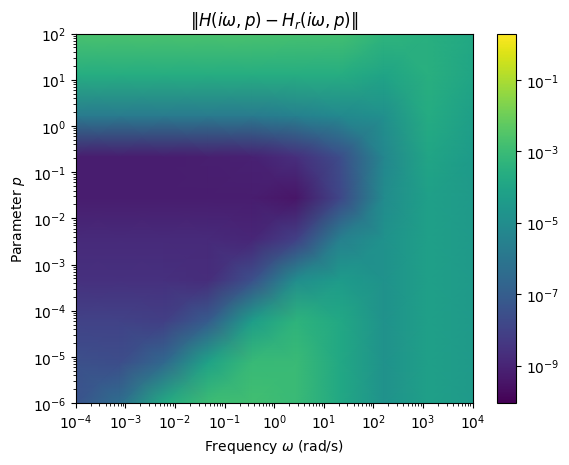

In [140]:
fig, ax = plt.subplots()
out = ax.pcolormesh(ws, ps, Hwp_err2, shading='gouraud', norm=lognorm)
ax.set(
    xscale='log',
    yscale='log',
    xlabel=r'Frequency $\omega$ (rad/s)',
    ylabel='Parameter $p$',
    title=r'$\Vert H(i \omega, p) - H_r(i \omega, p) \Vert$',
)
ax.grid(False)
_ = fig.colorbar(out)


## ROM Poles 2

In [141]:
for p in ps:
    poles = cookie_rom_g.poles(mu=p)
    print(poles.real.max())

-0.00011636209652931638
-0.0009009336275081077
-0.006974650579497609
-0.05394394125113548
-0.4134786133742721
-0.9999998819483147
-0.999999999973102
-0.9999999999703378
-0.9999999999686112
-0.9999915789614878


## Concluding Remarks

### Further MOR Methods

- #### nonlinear systems
- #### DEIM
- #### second-order systems
- #### time-delay systems
- #### modal truncation
- #### data-driven methods (p-AAA, Loewner, neural network based ROMs, ...)


## Using pyMOR

- #### installation: https://github.com/pymor/pymor#readme
- #### documentation: https://docs.pymor.org
- #### GitHub issues: https://github.com/pymor/pymor/issues
- #### GitHub discussions: https://github.com/pymor/pymor/discussions
- #### pyMOR community meetings: https://github.com/pymor/pymor/discussions/categories/announcements
- #### pyMOR School: https://school.pymor.org


## Contributing to pyMOR

- #### developer documentation: https://docs.pymor.org/latest/developer_docs.html
- #### get attribution via `AUTHORS.md`
- #### become contributor with push access to feature branches
- #### become main developer with full control over the project
